In [1]:
# -*- coding: utf-8 -*-
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from lxml import objectify
from pandas import DataFrame
from datetime import datetime, date, time
from dateutil.parser import parse
import pandas as pd
import numpy as np
import sklearn as sk
import time
import sys
from sklearn import metrics
import re

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [3]:
from __future__ import division

<h3>Сбор данных</h3>

In [4]:
stop_words = ['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', \
             'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', \
             'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', \
             'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', \
             'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', \
             'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', \
             'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', \
             'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', \
             'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', \
             'много', 'разве', 'три', 'эту', 'моя', 'впрочем', 'хорошо', 'свою', 'этой', 'перед', 'иногда', 'лучше', 'чуть', \
             'том', 'нельзя', 'такой', 'им', 'более', 'всегда', 'конечно', 'всю', 'между']

In [5]:
#Загрузка из датафрейма
df_count_word = pd.read_pickle('TMdata/df_count_word.pkl')

In [6]:
#Загрузка из датафрейма
df4 = pd.read_pickle('TMdata/df4.pkl')

In [7]:
mask = (df4['data'] >= '2005-01-01') & (df4['data'] < '2012-01-01')
df4_5500=df4.loc[mask]
print (df4_5500.count())

id          2430
content     2430
data        2430
category    2430
dtype: int64


In [8]:
mask = (df4['data'] >= '2012-01-01') & (df4['data'] < '2013-01-01')
df4_5500_new=df4.loc[mask]
print (df4_5500_new.count())

id          1129
content     1129
data        1129
category    1129
dtype: int64


In [9]:
category = df4_5500['category'].tolist()
content = df4_5500['content'].tolist()

<h3>Подготовка категорий</h3>

In [10]:
%%time
category2=[]
for line in category:
    lines = line.strip().split(', ')
    lis=""
    for li in lines:
        cat = "_".join(li.split(' '))
        lis += cat + " "
    category2.append(lis)
#print ("\n".join(category2))

Wall time: 10 ms


In [11]:
vectorizerContent = CountVectorizer (min_df=1, stop_words=stop_words)
vectorizerCategory = CountVectorizer (min_df=1)


In [12]:
%%time
pwd = vectorizerContent.fit_transform(content)
pdt = vectorizerCategory.fit_transform(category2)

Wall time: 937 ms


In [13]:
pwdT = pwd.toarray().transpose()
pdtT = pdt.toarray().transpose()

In [14]:
%%time
selected_feature_names_Cont = np.asarray(vectorizerContent.get_feature_names())
selected_feature_names_Cat = np.asarray(vectorizerCategory.get_feature_names())

Wall time: 167 ms


In [15]:
print len(selected_feature_names_Cat)
print len(selected_feature_names_Cont)

213
83849


In [ ]:
%%time
#Pwt - матрица тема документ
# Pwt = SUM(Ptd * Pdw)
i = 0
Pwt = 0
for xC in pdt:
    Pwt += np.array(xC.toarray())*np.array(pwd[i].toarray().transpose())
    #print (i)
    i += 1
#print (Pwt)

In [16]:
Pwt=np.load('TMdata/Pwt1.npy')

In [17]:
%%time
i1 = 0
Phi = np.arange(Pwt.size, dtype=float).reshape(Pwt.sum(axis=1).size, Pwt[0].size)
for el4 in Pwt.sum(axis=1):
    i2 = 0
    for el1 in Pwt[i1]:
        Phi[i1][i2]=float(el1)/Pwt[i1].sum()
        i2 += 1
    i1 += 1
print (Phi)

[[ 0.          0.          0.01052632 ...,  0.00350877  0.          0.        ]
 [ 0.0015625   0.          0.0078125  ...,  0.0015625   0.          0.0015625 ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]
Wall time: 1min 18s


In [18]:
Phi_T=Phi.copy()
Phi_T=Phi_T.transpose()

In [20]:
#количество документов в коллекции
countDoc = len(content)
print (countDoc)

2430


In [21]:
print ("Уникальных слов в обучении = %s" % len(Pwt.sum(axis=1)))
print ("Количество категорий = %s" % len(Pwt.sum(axis=0)))
print ("Слов в коллекции = %s" % Pwt.sum())
print ("Количество документов = %s" % df4_5500['id'].count())

Уникальных слов в обучении = 83849
Количество категорий = 213
Слов в коллекции = 1591531
Количество документов = 2430


<h1>Новые слова в корпусе</h1>

In [ ]:
%%time
mm=0
maxmm=1000
futureMatrixWord=[]
for index, row in df4_5500_new.iterrows():
    newReWord = re.sub(r'[\.|\,|\n|\"|\'|\«|\»|\(|\)]', ' ', row.content)
    newReWord = re.sub(r'[\s]+', ' ', newReWord)
    newD = vectorizerContent.transform(newReWord.split('\n')).toarray()
    sumNewD=newD.sum(axis=0)
    
    j = 0
    predictMatrix3 = []
    #Сумма слов по категориям
    #CatV=Pwt.sum(axis=0)
    #tfNewD = 0
    newDT=sumNewD.transpose()
    for inNew in np.nditer(sumNewD):
        
        if inNew > 0:
            wordInDoc = float(pwdT[j].sum())
            k = 0
            v_cat=[]
            for inCat in Pwt[j]:
                wordInCat = float(pdtT[k].sum())
                #check = Phi[j][k]*np.log(countDoc/wordInCat)*np.log(countDoc/wordInDoc)
                check = Phi[j][k]*(1-wordInCat/countDoc)*(1-wordInDoc/countDoc)*newDT[j]/sumNewD.sum()
                v_cat.append(check)
                k += 1
            predictMatrix3.append(v_cat)
        j+=1
    dfM3 = DataFrame(predictMatrix3)
    new_vec=dfM3.sum(axis=0)
    new_vec=new_vec/new_vec.sum()
    
    
    vectorizerContent_New_Word = CountVectorizer (min_df=1, stop_words=stop_words)
    pwd_New = vectorizerContent_New_Word.fit_transform(newReWord.split())
    selected_feature_names_Cont_New_Word = np.asarray(vectorizerContent_New_Word.get_feature_names())
    print len(selected_feature_names_Cont_New_Word), mm
    for l in selected_feature_names_Cont_New_Word:
        if l not in selected_feature_names_Cont:
            newWord=[]
            #print (u"Слова %s нет" % l)
            newWord.append(row['id'])
            newWord.append(l)
            newWord.append(new_vec)
            futureMatrixWord.append(newWord)
    
    if mm > maxmm:
        break
    #if mm%100==0:
        #print mm
    
    mm+=1
    

In [ ]:
dfNewWord=DataFrame(futureMatrixWord)

In [ ]:
dfNewWord.head(30)

In [ ]:
dfNewWord.count()

In [ ]:
dfM3.info()

In [ ]:
#Сохраняем датафрейм, чтобы постоянно не считать
dfNewWord.to_pickle('TMdata/dfNewWord.pkl')

In [22]:
#Загрузка из датафрейма
dfNewWord = pd.read_pickle('TMdata/dfNewWord.pkl')

In [23]:
dfNW=dfNewWord.copy()

In [24]:
dfNW.columns=['id', 'word', 'vector_tem']

In [25]:
dfNW.head()

,id,word,vector_tem
0,16751,аркадьев,0 0.000452 1 -0.000008 2 0.00100...
1,16751,дирижер,0 0.000452 1 -0.000008 2 0.00100...
2,16751,новогоднюю,0 0.000452 1 -0.000008 2 0.00100...
3,16764,императором,0 0.000505 1 -0.000047 2 -0.00005...
4,16764,иссии,0 0.000505 1 -0.000047 2 -0.00005...


In [26]:
dfNWGroupe=dfNW.groupby(['word'], as_index=False).count()

In [27]:
dfNWGroupe.head()

,word,id,vector_tem
0,00001,1,1
1,000110a,1,1
2,001,1,1
3,002,1,1
4,0027,1,1


In [166]:
dfNW_Sort=dfNW.groupby(['word']).filter(lambda x: x['word'].value_counts() > 1)
dfNW_Sort.head()

,id,word,vector_tem
2,16751,новогоднюю,0 0.000452 1 -0.000008 2 0.00100...
6,16764,неспособным,0 0.000505 1 -0.000047 2 -0.00005...
7,16764,неудач,0 0.000505 1 -0.000047 2 -0.00005...
10,16764,прозванный,0 0.000505 1 -0.000047 2 -0.00005...
12,16764,смешанные,0 0.000505 1 -0.000047 2 -0.00005...


In [167]:
dfNW_Sort.count()

id            8912
word          8912
vector_tem    8912
dtype: int64

In [168]:
dfGroupNW=dfNW_Sort.groupby(['word']).sum()

In [169]:
dfGroupNW.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3606 entries, 059 to ёсихико
Data columns (total 1 columns):
id    3606 non-null float64
dtypes: float64(1)
memory usage: 56.3+ KB


In [170]:
dfGruopSortNW=dfNW_Sort['word'].value_counts(normalize=False, sort=True, ascending=False, bins=None, dropna=True)

In [183]:
dfGruopSortNW.head(15)

pussy          25
riot           25
флорбол        13
флорболу       11
запрещённых    11
невинность     11
анатомия       10
развозжаев     10
пикселей        9
бергер          9
повинной        9
мурси           9
частотой        8
развозжаева     8
208             8
Name: word, dtype: int64

In [200]:
mask_new_word = (dfNW_Sort['word'] == u'пикселей')
df_new_word_filter=dfNW_Sort.loc[mask_new_word]
df_new_word_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9 entries, 13242 to 24691
Data columns (total 3 columns):
id            9 non-null float64
word          9 non-null object
vector_tem    9 non-null object
dtypes: float64(1), object(2)
memory usage: 288.0+ bytes


In [201]:
matrix_new_word=df_new_word_filter['vector_tem']

In [202]:
count_val=213*len(matrix_new_word)
print count_val
NP_Word_Matrix = np.arange(count_val, dtype=float).reshape(len(matrix_new_word), 213)

1917


In [203]:
i1=0
for row in matrix_new_word:
    i2=0
    for el1 in row:
        NP_Word_Matrix[i1][i2] = el1
        i2+=1
    i1+=1
print len(NP_Word_Matrix)
    
    
    

9


<h2>Сумма векторов тем</h2>

In [204]:
Sum_NP=NP_Word_Matrix.sum(axis=0)
sum_vector_tem_norm=[]
for l in Sum_NP:
    check = l/sum(Sum_NP)
    if check < 0:
        zz=0
    else:
        zz=check
    sum_vector_tem_norm.append(zz)
print sum(sum_vector_tem_norm), len(sum_vector_tem_norm)

1.0 213


In [205]:
NP_T=NP_Word_Matrix.transpose()

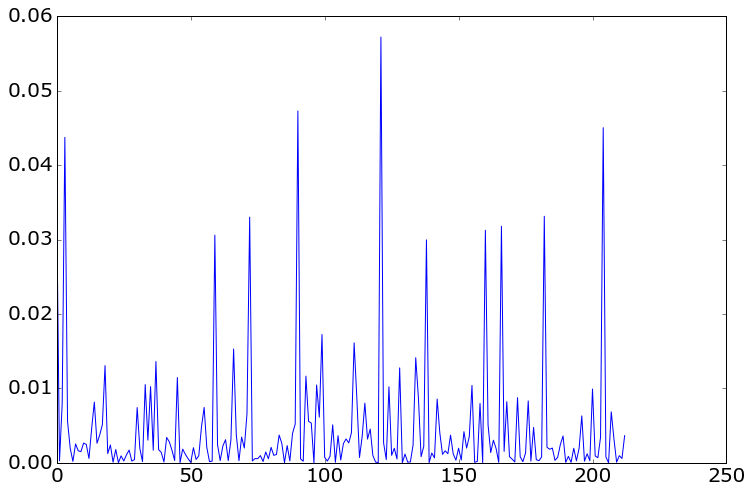

In [206]:
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='red')
plt.plot(sum_vector_tem_norm)

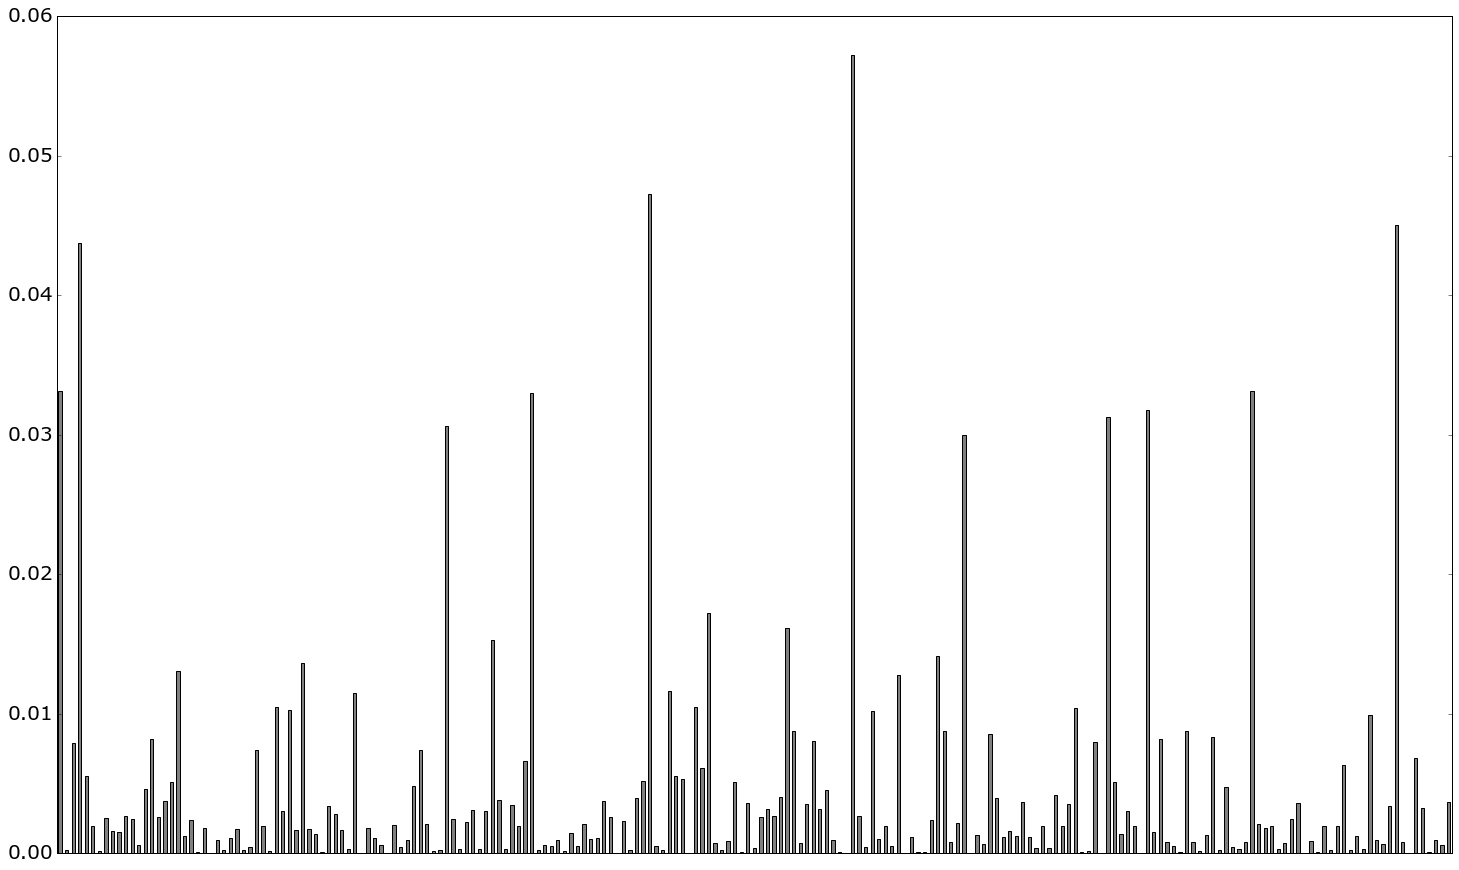

In [207]:
df_count_word_all=pd.DataFrame(sum_vector_tem_norm)
df_count_word_all.plot.bar(color='gray', legend=None)
plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off') 
rcParams['font.family'] = 'Verdana'
rcParams['font.size'] = 20
rcParams['figure.figsize'] = 25, 15
rcParams['figure.facecolor'] = 'white'
rcParams['figure.edgecolor'] = 'black'
rcParams['figure.edgecolor'] = 'gray'
plt.show()

In [208]:
i=0
predictMatrixW=[]
for l in sum_vector_tem_norm:
    if l > 0:
        el_data= {}
        el_data[selected_feature_names_Cat[i]]=l
        predictMatrixW.append(dict(el_data))
        #print selected_feature_names_Cat[i], l
    i+=1
dfMW = DataFrame(predictMatrixW)
dfSumMW=dfMW.sum()
k=0
dfSumMW.sort_values(ascending=False, kind='quicksort', na_position='last', inplace=True)
for el in dfSumMW.T.iteritems():
    if el[1]>0.01:
        print ("%s) %s = %f" % (k, el[0], el[1]))
    
    k+=1

0) наука_и_технологии = 0.057219
1) компьютерные_технологии = 0.047289
2) экономика = 0.045041
3) hardware = 0.043748
4) сша = 0.033134
5) apple = 0.033118
6) интернет = 0.033018
7) россия = 0.031799
8) рейтинги = 0.031262
9) европа = 0.030599
10) политика = 0.029965
11) культура = 0.017246
12) мкс = 0.016127
13) забавное = 0.015296
14) опубликовано = 0.014123
15) владимир_путин = 0.013611
16) астрономия = 0.013068
17) общество = 0.012760
18) космонавтика = 0.011651
19) германия = 0.011461
20) викивестник = 0.010516
21) криминал = 0.010464
22) преступность_и_право = 0.010397
23) википедия = 0.010238
24) новосибирск = 0.010216


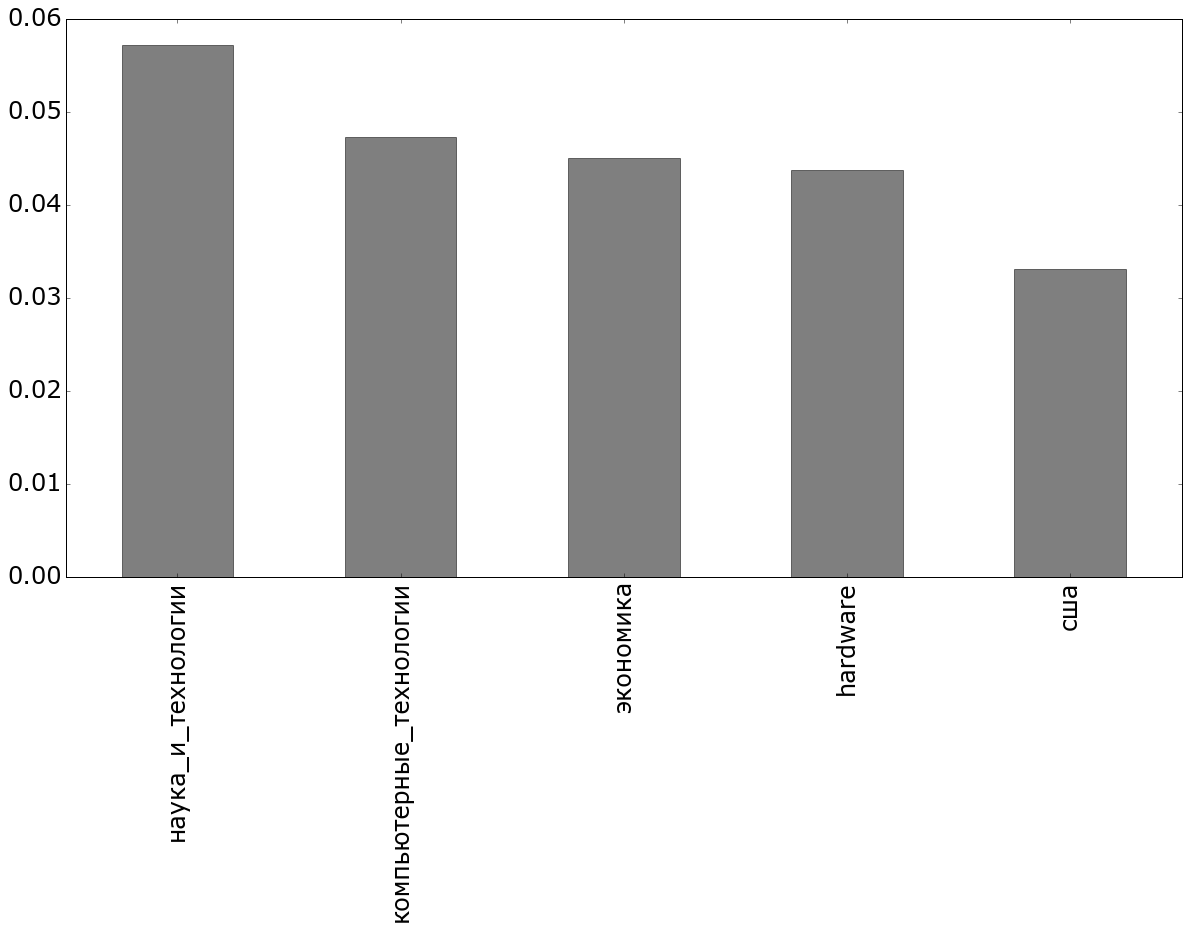

In [209]:
dfV2=dfSumMW[0:5]
rcParams['font.family'] = 'verdana'
rcParams['legend.fontsize'] = 24
#xlabel(u"Категории")
dfV2.plot.bar(figsize=(20, 10), alpha=0.5, color='000', label=u'Кат', fontsize='24');

<h2>Произведение Адамара векторов тем</h2>

In [210]:
i=0
vector_tem=[]
for x in np.nditer(NP_Word_Matrix, flags=['external_loop'], order='F'):
    #print i, x,
    c=1
    j=0
    for y in np.nditer(x):
        c=c*y
        #print i, j, c, y
        j+=1
    if c > 0:
        vector_tem.append(c)
    else:
        vector_tem.append(0.0)
    i+=1
print len(vector_tem), sum(vector_tem)
#plt.plot(vector_tem)
vector_tem_norm=[]
for l in vector_tem:
    check = l/sum(vector_tem)
    if check < 0:
        zz=0
    else:
        zz=check
    vector_tem_norm.append(zz)
print sum(vector_tem_norm), len(vector_tem_norm)

213 7.8307083211e-12
1.0 213


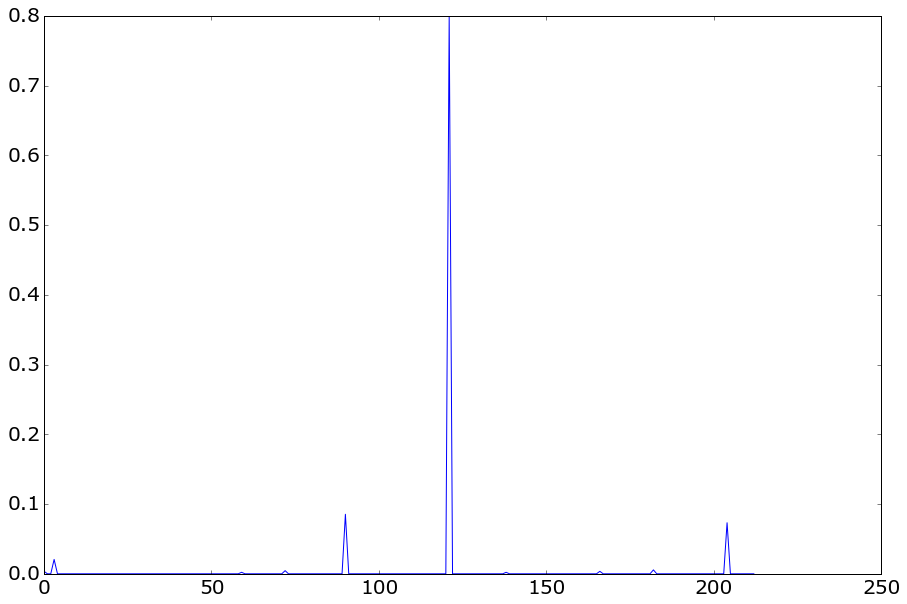

In [211]:
plt.figure(num=None, figsize=(15, 10), )
plt.plot(vector_tem_norm)

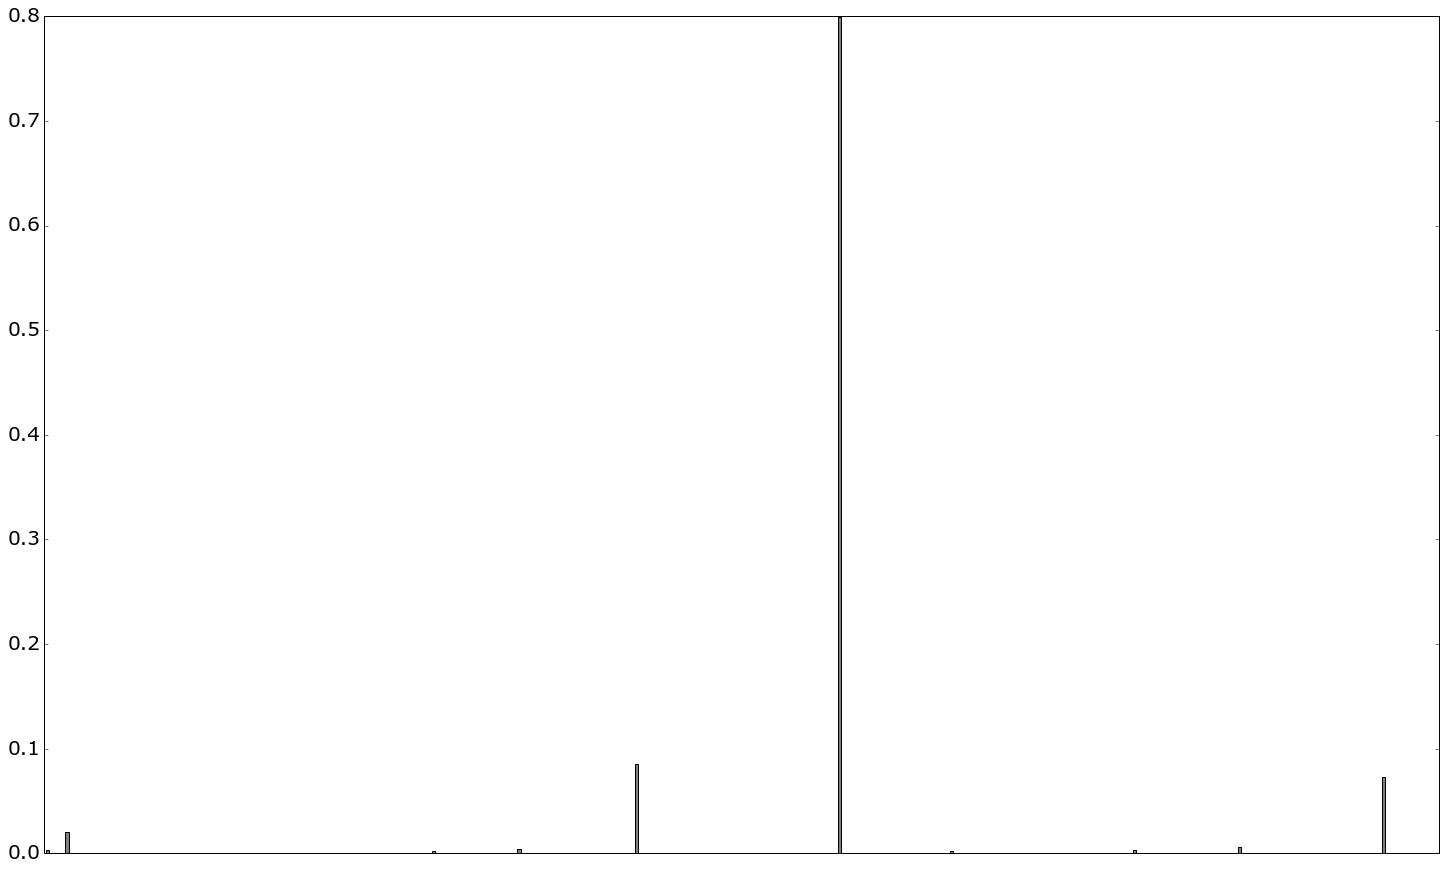

In [212]:
df_count_word_all=pd.DataFrame(vector_tem_norm)
df_count_word_all.plot.bar(color='gray', legend=None)
plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off') 
rcParams['font.family'] = 'Verdana'
rcParams['font.size'] = 20
rcParams['figure.figsize'] = 25, 15
rcParams['figure.facecolor'] = 'white'
rcParams['figure.edgecolor'] = 'black'
rcParams['figure.edgecolor'] = 'gray'
plt.show()

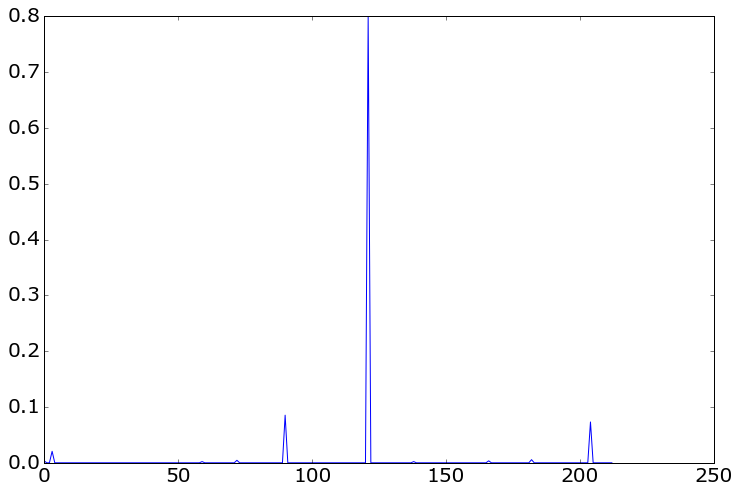

In [213]:
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='red')
plt.plot(vector_tem_norm)

In [214]:
i=0
predictMatrixW=[]
for l in vector_tem_norm:
    if l > 0:
        el_data= {}
        el_data[selected_feature_names_Cat[i]]=l
        predictMatrixW.append(dict(el_data))
        #print selected_feature_names_Cat[i], l
    i+=1
dfMW = DataFrame(predictMatrixW)
dfSumMW=dfMW.sum()
k=1
dfSumMW.sort_values(ascending=False, kind='quicksort', na_position='last', inplace=True)
for el in dfSumMW.T.iteritems():
    if el[1]>0.01:
        print ("%s) %s = %f" % (k, el[0], el[1]))
        
    
    k+=1

1) наука_и_технологии = 0.799283
2) компьютерные_технологии = 0.085331
3) экономика = 0.073189
4) hardware = 0.020596


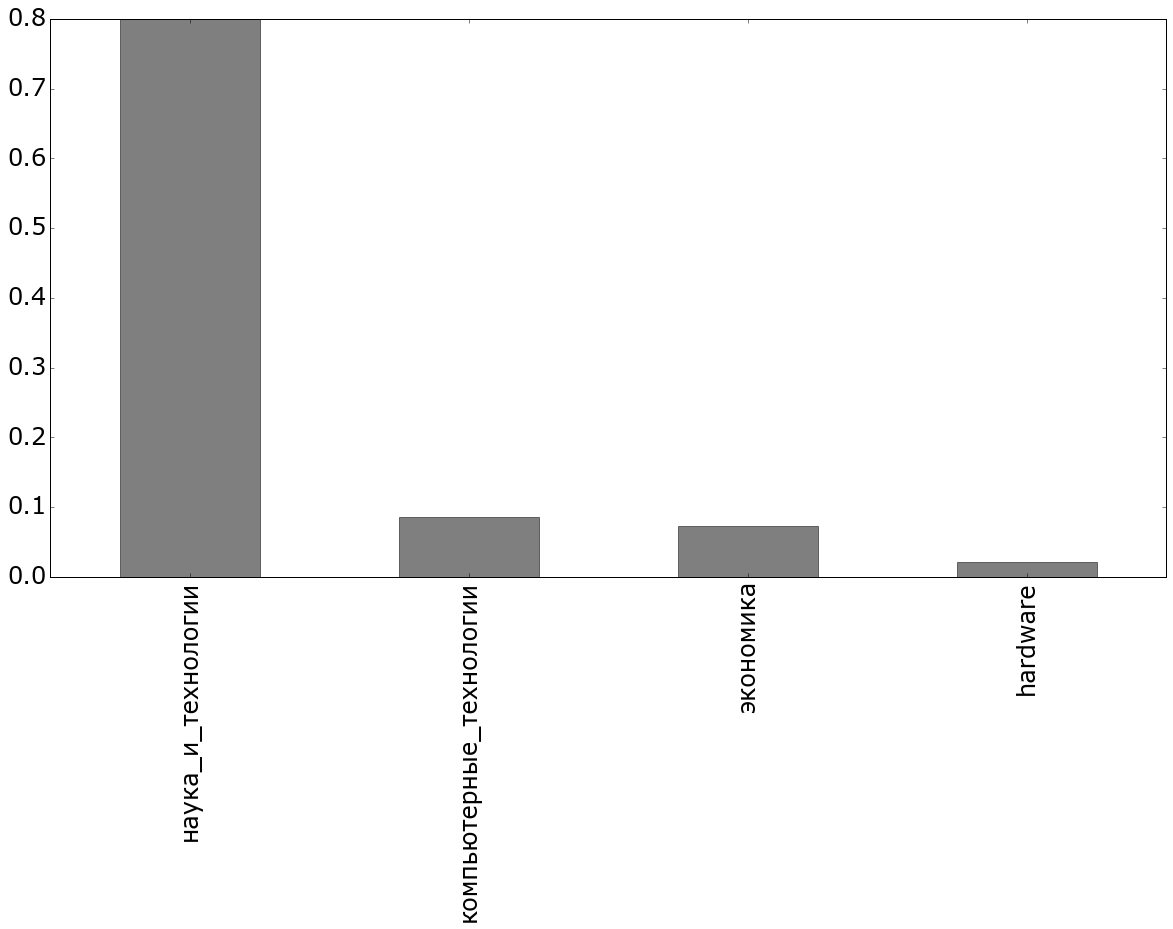

In [215]:
dfV2=dfSumMW[0:4]
rcParams['font.family'] = 'verdana'
rcParams['legend.fontsize'] = 24
#xlabel(u"Категории")
dfV2.plot.bar(figsize=(20, 10), alpha=0.5, color='000', label=u'Кат', fontsize='24');

<h2>Поиск обнуленных векторов</h2>

In [172]:
len(dfGruopSortNW)

3606

In [173]:
%%time
for name, colvo in dfGruopSortNW.iteritems():
    m_mask_new_word=(dfNW_Sort['word'] == name)
    m_df_new_word_filter=dfNW_Sort.loc[m_mask_new_word]
    m_matrix_new_word=m_df_new_word_filter['vector_tem']
    count_val=213*len(m_matrix_new_word)
    m_NP_Word_Matrix = np.arange(count_val, dtype=float).reshape(len(m_matrix_new_word), 213)
    i1=0
    for row in m_matrix_new_word:
        i2=0
        for el1 in row:
            m_NP_Word_Matrix[i1][i2] = el1
            i2+=1
        i1+=1
    i=0
    #print len(m_NP_Word_Matrix)
    m_vector_tem=[]
    for x in np.nditer(m_NP_Word_Matrix, flags=['external_loop'], order='F'):
        c=1
        j=0
        for y in np.nditer(x):
            c=c*y
            j+=1
        if c>0:
            m_vector_tem.append(c)
        else:
            m_vector_tem.append(0.0)
        i+=1
    #print sum(m_vector_tem)
    m_vector_tem_norm=[]
    for l in m_vector_tem:
        check=l/sum(m_vector_tem)
        if check<0:
            zz=0
        else:
            zz=check
        m_vector_tem_norm.append(zz)
    #print sum(m_vector_tem_norm)
    
    if sum(m_vector_tem_norm) == 0:
        print sum(m_vector_tem), len(m_NP_Word_Matrix), sum(m_vector_tem_norm)
   
    

Wall time: 24.1 s
